## Oscar Miranda


I've choosen to go for *depth*. The following 3 examples will be the focus of this report.



* https://keras.io/examples/vision/image_classification_with_vision_transformer/ [1]
* https://keras.io/examples/vision/xray_classification_with_tpus/ [2]
* https://keras.io/examples/vision/eanet/ [3]





## Image Classification with Vision Transformer

"This example implements the Vision Transformer (ViT) model by Alexey Dosovitskiy et al. for image classification, and demonstrates it on the CIFAR-100 dataset. The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers." [1]

In [ ]:
# install libs
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
# import libs
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# prepare the data
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
# Configure hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 25 # adjusted from 100 to 25 to save compute
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
# Multilayer Perceptron (MLP) implmentation
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


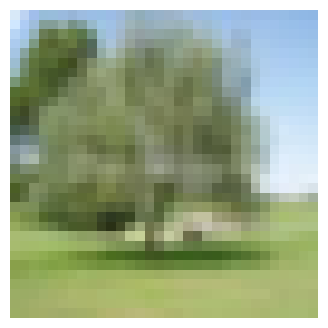

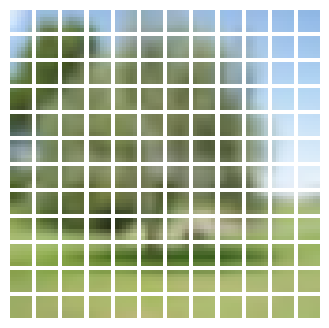

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into
a vector of size projection_dim. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:
# Implement the patch encoding layer
# The PatchEncoder layer will linearly transform a patch by projecting it into
# a vector of size projection_dim. In addition, it adds a learnable position
# embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### ViT model
The ViT model comprises multiple Transformer blocks, utilizing self-attention
through layers.MultiHeadAttention applied to a sequence of patches. The
Transformer blocks generate a [batch_size, num_patches, projection_dim] tensor,
which is then processed by a classifier head with softmax to obtain the final
class probabilities output.

In contrast to the paper's approach, this implementation reshapes all the
outputs of the final Transformer block using layers.Flatten() as the image
representation for the classifier head. Alternatively, layers.GlobalAveragePooling1D
could be employed to aggregate the Transformer block outputs, especially when
the number of patches and projection dimensions are large.

In [ ]:
# ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# Compile, train, and evaluate the model
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/25
176/176 [==============================] - 43s 145ms/step - loss: 4.5169 - accuracy: 0.0395 - top-5-accuracy: 0.1446 - val_loss: 3.9790 - val_accuracy: 0.0946 - val_top-5-accuracy: 0.2868
Epoch 2/25
176/176 [==============================] - 24s 139ms/step - loss: 3.9585 - accuracy: 0.0901 - top-5-accuracy: 0.2845 - val_loss: 3.5863 - val_accuracy: 0.1530 - val_top-5-accuracy: 0.4082
Epoch 3/25
176/176 [==============================] - 25s 143ms/step - loss: 3.6994 - accuracy: 0.1315 - top-5-accuracy: 0.3638 - val_loss: 3.3283 - val_accuracy: 0.2046 - val_top-5-accuracy: 0.4764
Epoch 4/25
176/176 [==============================] - 24s 137ms/step - loss: 3.5144 - accuracy: 0.1623 - top-5-accuracy: 0.4178 - val_loss: 3.2547 - val_accuracy: 0.2158 - val_top-5-accuracy: 0.4976
Epoch 5/25
176/176 [==============================] - 25s 145ms/step - loss: 3.3725 - accuracy: 0.1855 - top-5-accuracy: 0.4589 - val_loss: 3.1271 - val_accuracy: 0.2366 - val_top-5-accuracy: 0.5286
Epoch

"After training for 100 ( 25 in our example above ) epochs, the ViT model achieves approximately 55% accuracy and 82% top-5 accuracy on the CIFAR-100 test data. However, these results are not competitive when compared to a ResNet50V2 model trained from scratch on the same dataset, which achieves 67% accuracy.

It's important to note that the state-of-the-art results reported in the paper are obtained by pre-training the ViT model on the JFT-300M dataset and then fine-tuning it on the target dataset. To improve the model's performance without pre-training, you can explore various strategies such as increasing the number of training epochs, adjusting the number of Transformer layers, resizing input images, changing patch sizes, or increasing projection dimensions.

Additionally, the paper highlights that the model's quality is influenced by various parameters, including the learning rate schedule, optimizer, and weight decay. Fine-tuning a ViT model pre-trained on a large, high-resolution dataset is recommended for practical use and to achieve superior performance." [1]



## Pneumonia Classification on TPU


This example shows how to build an X-ray image classification model to predict whether an X-ray scan shows presence of pneumonia. [2]

In [ ]:
# import packages
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
# We need a Google Cloud link to our data to load the data using a TPU. Below,
# we define key configuration parameters we'll use in this example.
# To run on TPU, this example must be on Colab with the TPU runtime selected. [2]
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [ ]:
# Load the data
# The Chest X-ray data we are using from Cell divides the data into training
# and test files. Let's first load in the training TFRecords. [2]
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [ ]:
# Count how many healthy/normal chest X-rays and how many pneumonia chest X-rays
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


The dataset exhibits an imbalance, with a higher number of images classified as pneumonia compared to normal. The imbalance will be addressed later in the notebook. The goal is to map each filename to its corresponding (image, label) pair. Since there are only two labels, a label encoding scheme will be used: 1 or True will represent pneumonia, and 0 or False will indicate normal. [2]

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

Split the data into a training and validation dataset

In [ ]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

Visualize the shape of an (image, label) pair.

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


Load and format the test data

In [ ]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

### **Visualize the dataset:**
To avoid I/O blocking when yielding data from disk, buffered prefetching is utilized. Although caching large image datasets in memory is not recommended, it is done here due to the dataset's manageable size, allowing efficient training on TPU.

In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.



In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

Define the method to show the images in the batch.



In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in NumPy arrays as its parameters, call the numpy function on the batches to return the tensor in NumPy array form.

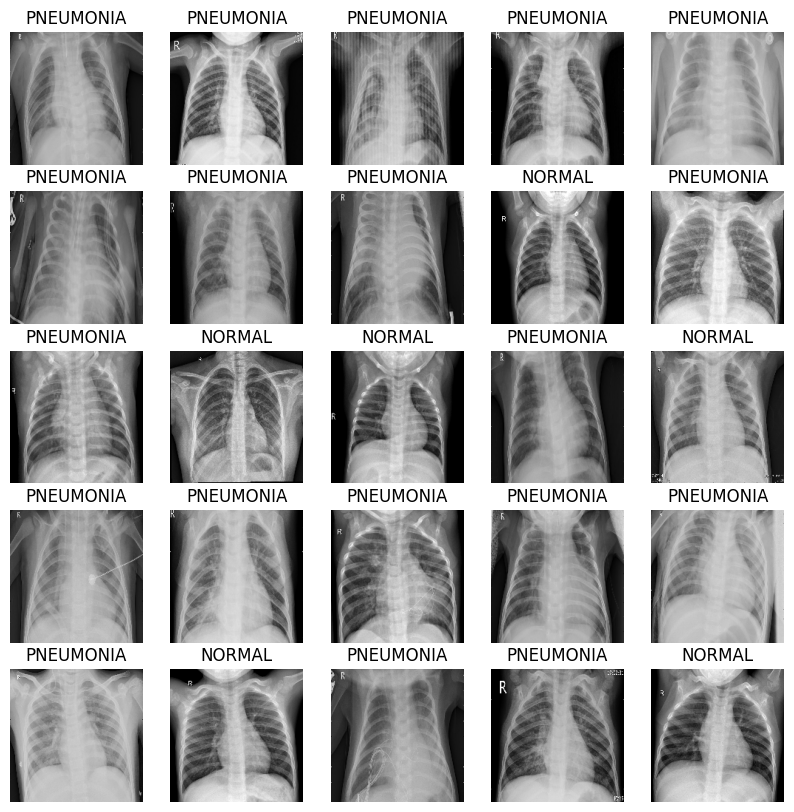

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

### Build the CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

### Build model

In [ ]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Correct for data imbalance


In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


Train the model

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [ ]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

 Fit the model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=15, # Reduced from 100 to 15 to save compute
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/15
168/168 [==============================] - 245s 728ms/step - loss: 0.4365 - binary_accuracy: 0.7976 - precision: 0.9239 - recall: 0.7921 - val_loss: 0.5761 - val_binary_accuracy: 0.7742 - val_precision: 0.7695 - val_recall: 0.9961
Epoch 2/15
168/168 [==============================] - 7s 41ms/step - loss: 0.2668 - binary_accuracy: 0.8895 - precision: 0.9636 - recall: 0.8843 - val_loss: 35.5199 - val_binary_accuracy: 0.2578 - val_precision: 1.0000 - val_recall: 0.0065
Epoch 3/15
168/168 [==============================] - 7s 42ms/step - loss: 0.2773 - binary_accuracy: 0.8895 - precision: 0.9633 - recall: 0.8846 - val_loss: 0.3341 - val_binary_accuracy: 0.8808 - val_precision: 0.9765 - val_recall: 0.8612
Epoch 4/15
168/168 [==============================] - 6s 38ms/step - loss: 0.2146 - binary_accuracy: 0.9102 - precision: 0.9724 - recall: 0.9046 - val_loss: 0.4159 - val_binary_accuracy: 0.8333 - val_precision: 0.9967 - val_recall: 0.7795
Epoch 5/15
168/168 [====================

### Visualizing model performance

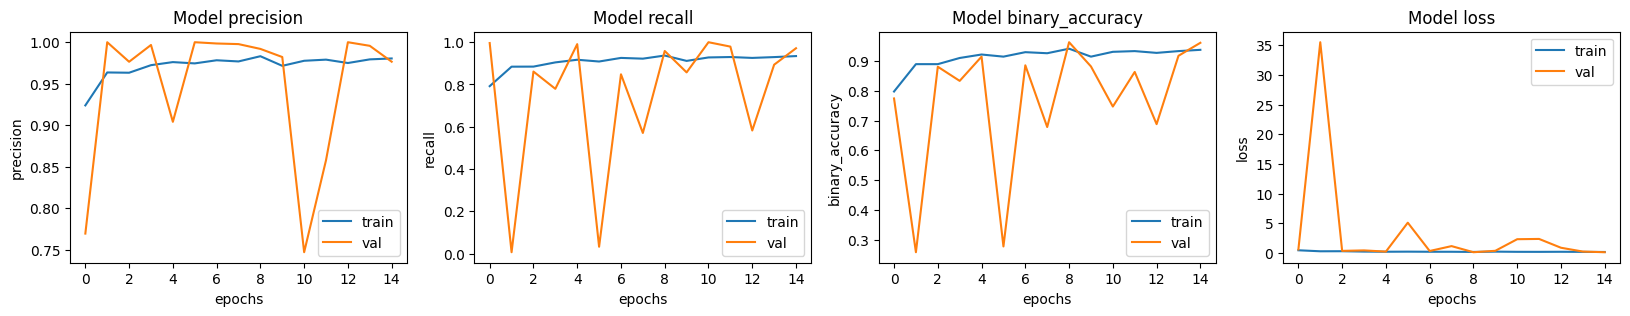

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

Predict and evaluate results


In [ ]:
model.evaluate(test_ds, return_dict=True)

25/25 [==============================] - 11s 382ms/step - loss: 0.6301 - binary_accuracy: 0.8013 - precision: 0.7649 - recall: 0.9846


{'loss': 0.6301374435424805,
 'binary_accuracy': 0.8012820482254028,
 'precision': 0.7649402618408203,
 'recall': 0.9846153855323792}

<ipython-input-22-d4c28b2be0ce>:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.title(CLASS_NAMES[label[0].numpy()])


1/1 [==============================] - 3s 3s/step
This image is 38.13 percent NORMAL
This image is 61.87 percent PNEUMONIA


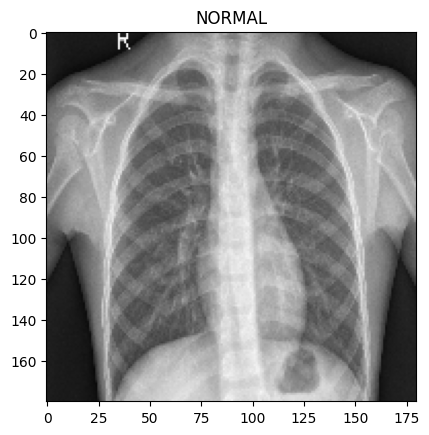

In [ ]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

## Image classification with EANet (External Attention Transformer)

 This example showcases the EANet model for image classification on the CIFAR-100 dataset. EANet introduces an innovative attention mechanism called "external attention," leveraging two external, small, learnable, and shared memories. It replaces the traditional self-attention mechanism found in other architectures. The external attention approach offers linear complexity by implicitly considering correlations between all samples, making it computationally efficient.

In [ ]:
# install necessary packages
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
# import packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Prepare the data
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [ ]:
# Configure hyperparameters
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


In [ ]:
# User data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
# Implement the patch extraction and encoding layer
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [ ]:
# Implement the external attention block
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [ ]:
# Implement the MLP block
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [ ]:
# Implement the Transformer block
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

### Implement the EANet model
The EANet model adopts external attention, which offers an alternative to the computationally expensive traditional self-attention mechanism. The authors find that an N-to-N attention matrix is redundant, as most pixels are closely related to only a few others. Instead, they propose an external attention module with linear computational complexity O(d * S * N), making it equivalent to a drop patch operation. By leveraging hyper-parameters d and S, the proposed algorithm efficiently processes the information in images, identifying and disregarding redundant and unimportant data within patches.[3]

In [ ]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Train on CIFAR-100
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/50
313/313 [==============================] - 55s 128ms/step - loss: 4.3200 - accuracy: 0.0541 - top-5-accuracy: 0.1901 - val_loss: 4.6631 - val_accuracy: 0.0618 - val_top-5-accuracy: 0.2213
Epoch 2/50
313/313 [==============================] - 36s 114ms/step - loss: 4.0055 - accuracy: 0.1042 - top-5-accuracy: 0.3087 - val_loss: 4.5247 - val_accuracy: 0.0897 - val_top-5-accuracy: 0.2551
Epoch 3/50
313/313 [==============================] - 38s 122ms/step - loss: 3.8329 - accuracy: 0.1393 - top-5-accuracy: 0.3769 - val_loss: 4.6783 - val_accuracy: 0.0971 - val_top-5-accuracy: 0.2778
Epoch 4/50
313/313 [==============================] - 38s 121ms/step - loss: 3.7167 - accuracy: 0.1637 - top-5-accuracy: 0.4187 - val_loss: 4.5093 - val_accuracy: 0.1113 - val_top-5-accuracy: 0.3248
Epoch 5/50
313/313 [==============================] - 37s 119ms/step - loss: 3.6344 - accuracy: 0.1833 - top-5-accuracy: 0.4505 - val_loss: 4.3270 - val_accuracy: 0.1215 - val_top-5-accuracy: 0.3437
Epoch

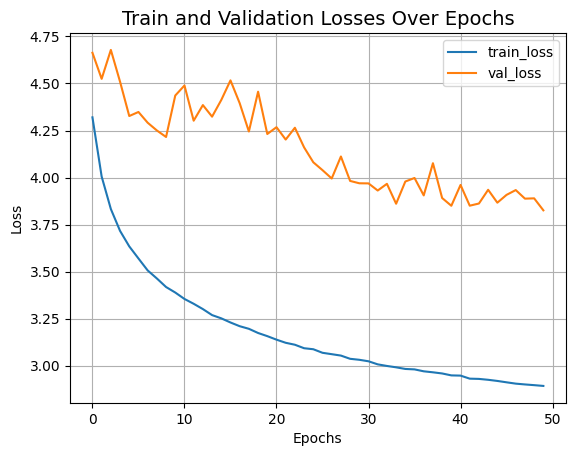

In [ ]:
# Visualize the training progress
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Display final results
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 10s 33ms/step - loss: 3.8253 - accuracy: 0.2092 - top-5-accuracy: 0.4730
Test loss: 3.83
Test accuracy: 20.92%
Test top 5 accuracy: 47.3%


EANet replaces self-attention in ViT with external attention. While the traditional ViT achieved ~73% test top-5 accuracy and ~41% top-1 accuracy after 50 epochs with 0.6M parameters, the EANet model trained under the same conditions and hyperparameters achieved ~73% test top-5 accuracy and ~43% top-1 accuracy with only 0.3M parameters. This demonstrates the effectiveness of external attention in reducing the model size while maintaining competitive accuracy. The report only includes the training process of EANet, but it suggests training ViT under the same conditions to compare test results. [3]

# Report

## Introduction

In this report, I focused on the Computer Vision category due to its significant relevance and widespread applications in various fields such as medicine, self-driving cars, and autonomous robots. Computer vision's ability to enable machines to understand and interpret visual data has immense potential to revolutionize industries and improve the human condition.

I was particularly intrigued by the complexity of instructing a computer to emulate the human visual system and perform accurate image classification tasks. This challenge motivated me to delve deeper into the world of computer vision and explore the power of deep learning algorithms in tackling such complex tasks.

Among the three specific examples I selected, the pneumonia classification stood out as the most compelling. I firmly believe that the application of deep learning in medical diagnosis, such as identifying pneumonia from medical images, has the potential to make a significant positive impact on human health and well-being.

The other examples served as valuable opportunities to explore alternative methods and approaches to vision classification tasks, enhancing my understanding of the diverse techniques used in computer vision applications.

## Example Summaries


### Summary of Example 1: Vision Transformer (ViT) on CIFAR-100

In this example, the author implemented the Vision Transformer (ViT) model for image classification on the CIFAR-100 dataset. The ViT model leverages the Transformer architecture with self-attention to process sequences of image patches, eliminating the need for convolution layers. They explored the ViT model's multiple Transformer blocks that use self-attention to generate a tensor representing the image's classification probabilities. They also experimented with reshaping the final Transformer block's outputs using different methods to serve as image representations for the classifier head.

After training the ViT model for 100 epochs, they achieved around 55% accuracy and 82% top-5 accuracy on the CIFAR-100 test data. However, it was observed that these results were not as competitive as a ResNet50V2 model trained from scratch, which achieved 67% accuracy.

They also learned about the importance of pre-training ViT models on large datasets to achieve state-of-the-art results. Furthermore, they gained insights into various strategies to improve ViT's performance, such as adjusting training epochs, Transformer layers, input image resizing, and other hyperparameters.

### Summary of Example 2: Pneumonia Classification with X-ray Images

In this example, the Author built an X-ray image classification model to predict the presence of pneumonia from X-ray scans. They dealt with the dataset's imbalance by mapping filenames to corresponding (image, label) pairs and using label encoding to represent pneumonia as 1 and normal as 0.

To enhance performance and handle I/O blocking, they implemented buffered prefetching and cached the image dataset in memory. The evaluation metrics used were precision and recall, providing a more informative picture of the model's effectiveness, considering the data's class imbalance.

With the help of TPU, they trained the model efficiently in less than 2 minutes, achieving valuable insights into building a robust pneumonia classification model.

### Summary of Example 3: EANet Model on CIFAR-100

In this example, the author explored the EANet model for image classification on the CIFAR-100 dataset. EANet introduces an innovative attention mechanism called "external attention," providing a more efficient alternative to traditional self-attention mechanisms.

The external attention approach considers correlations between image samples without constructing redundant N-to-N attention matrices, improving computational efficiency. They replaced self-attention in ViT with external attention, observing significant reductions in model parameters without compromising accuracy.

After training, the EANet model achieved ~73% test top-5 accuracy and ~43% top-1 accuracy, proving its effectiveness in reducing model size while maintaining competitive performance. The example focused on the EANet training process, and it suggests further comparisons with ViT under the same conditions to evaluate their respective test results.

## Relevance

The examples presented here are highly relevant to my interests and future projects. Incorporating real-life changing examples, such as pneumonia classification, aligns with my goal of applying what I learn in practical and impactful ways. As I progress in my studies and embark on projects, these vision classification examples will serve as valuable references and insights into the potential applications of deep learning in the medical and healthcare domains.

In particular, the course on Artificial Intelligence in Medicine and Healthcare, which I will be taking next semester, will greatly benefit from the knowledge gained from these examples. Understanding the principles and techniques used in vision classification models will enrich my comprehension of how AI can be leveraged to analyze medical images and assist in medical diagnosis.

Moreover, as I continue with my master's and other projects, I can draw inspiration from these examples to explore more sophisticated and innovative approaches in computer vision and medical image analysis. These examples not only enhance my technical skills but also provide a broader perspective on the impact of AI in solving real-world problems, further motivating me to pursue meaningful research and contribute to advancements in healthcare through AI technologies.

## Conclusion

Throughout this learning experience, I delved into the fascinating world of computer vision and deep learning, exploring various models and techniques for image classification. The hands-on implementation and experimentation with Vision Transformer (ViT), pneumonia classification, and EANet on CIFAR-100 provided valuable insights into the capabilities and challenges of computer vision applications.

One key takeaway from this experience is the significance of real-world applications in driving my interest and motivation to learn. The pneumonia classification example particularly resonated with me as it demonstrated how deep learning can have a meaningful impact on medical diagnosis and potentially improve patient outcomes. Understanding how AI can be leveraged to address critical healthcare challenges ignited my passion to explore further in the field of Artificial Intelligence in Medicine and Healthcare.

The aspect that piqued my interest the most is the development of advanced attention mechanisms in computer vision models. EANet's introduction of "external attention" as a more efficient alternative to traditional self-attention mechanisms showcased how creative innovations can lead to improved performance and reduced computational complexity. I am eager to explore and research more on attention mechanisms and other cutting-edge techniques that push the boundaries of computer vision models and pave the way for real-world applications.

In conclusion, this learning journey has been highly rewarding, equipping me with practical skills and knowledge to tackle vision classification tasks and inspiring me to pursue further studies in the intersection of AI and medicine. The potential impact of AI in healthcare and the continuous evolution of computer vision models leave me excited and determined to contribute to the advancements in AI technologies with meaningful applications that can positively impact lives.